In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
import pandas as pd
import seaborn as sns

In [23]:
# **Step 1: Define the folders**
folders = ["GLCM_AMS_Result", "GLCM_Contrast_Result", "GLCM_Dissimilarity_Result",
           "GLCM_Energy_Result", "GLCM_Entropy_Result", "GLCM_Homogeneity_Result",
           "GLCM_Max_Result", "GLCM_Mean_Result", "GLCM_Standard_Result",
           "RGB_Images_Result"]

In [24]:
# **Step 2: Create a function to load data**
def load_data(folder):
    histories = []
    confusion_matrices = []
    all_val_auc = []
    for fold in range(1, 11):
        history_path = os.path.join(folder, f"fold_{fold}_history.csv")
        cm_path = os.path.join(folder, f"fold_{fold}_confusion_matrix_data.csv")
        histories.append(pd.read_csv(history_path))
        confusion_matrices.append(pd.read_csv(cm_path))
    with open(os.path.join(folder, "all_val_auc.json"), "r") as f:
        all_val_auc = json.load(f)
    return histories, confusion_matrices, all_val_auc


In [25]:
# **Step 3: Load data for each folder**
all_histories = []
all_confusion_matrices = []
all_auc_values = []
for folder in folders:
    histories, confusion_matrices, all_val_auc = load_data(folder)
    all_histories.append(histories)
    all_confusion_matrices.append(confusion_matrices)
    all_auc_values.append(all_val_auc)


In [26]:
# **Step 4: Calculate and compare average metrics**
results = []
for i, folder in enumerate(folders):
    avg_train_loss = np.mean([history["train_loss"].values[-1] for history in all_histories[i]])
    avg_val_loss = np.mean([history["val_loss"].values[-1] for history in all_histories[i]])
    avg_train_acc = np.mean([history["train_acc"].values[-1] for history in all_histories[i]])
    avg_val_acc = np.mean([history["val_acc"].values[-1] for history in all_histories[i]])
    avg_auc = np.mean(all_auc_values[i])

    f1_scores = []
    for fold in range(10):
        cm_data = all_confusion_matrices[i][fold]
        f1 = f1_score(cm_data["true_labels"], cm_data["predicted_labels"])
        f1_scores.append(f1)
    avg_f1 = np.mean(f1_scores)

    results.append({
        "Feature": folder,
        "Avg Train Loss": avg_train_loss,
        "Avg Val Loss": avg_val_loss,
        "Avg Train Acc": avg_train_acc,
        "Avg Val Acc": avg_val_acc,
        "Avg AUC": avg_auc,
        "Avg F1-score": avg_f1
    })


In [27]:
# **Step 5: Create and display the results table**
df_results = pd.DataFrame(results)
print(df_results.to_markdown(index=False, numalign="left", stralign="left"))

| Feature                   | Avg Train Loss   | Avg Val Loss   | Avg Train Acc   | Avg Val Acc   | Avg AUC   | Avg F1-score   |
|:--------------------------|:-----------------|:---------------|:----------------|:--------------|:----------|:---------------|
| GLCM_AMS_Result           | 1.37464e-05      | 0.632558       | 1               | 0.915292      | 0.956756  | 0.918076       |
| GLCM_Contrast_Result      | 0.0067113        | 0.54663        | 0.99838         | 0.924435      | 0.962432  | 0.92675        |
| GLCM_Dissimilarity_Result | 7.36709e-06      | 0.546135       | 1               | 0.930898      | 0.967283  | 0.932582       |
| GLCM_Energy_Result        | 1.11149e-05      | 0.680144       | 1               | 0.916184      | 0.957403  | 0.919189       |
| GLCM_Entropy_Result       | 5.90775e-06      | 0.523554       | 1               | 0.935026      | 0.970698  | 0.936445       |
| GLCM_Homogeneity_Result   | 1.64976e-05      | 0.565505       | 1               | 0.924507     

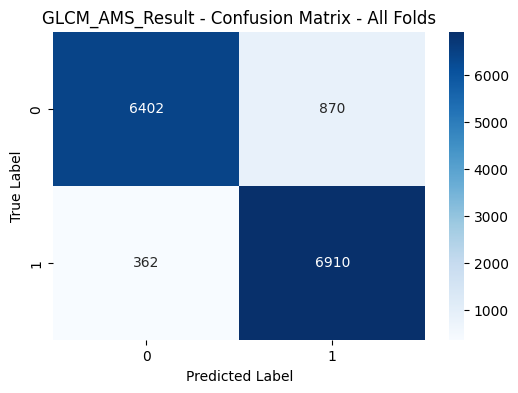

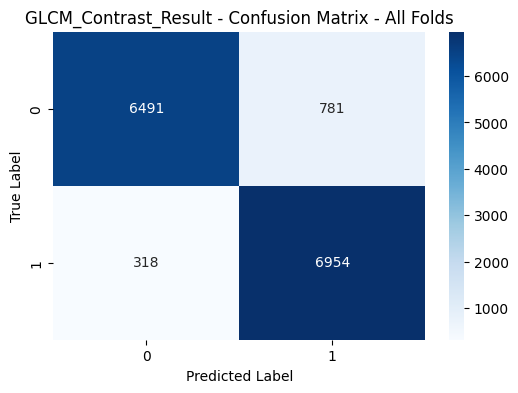

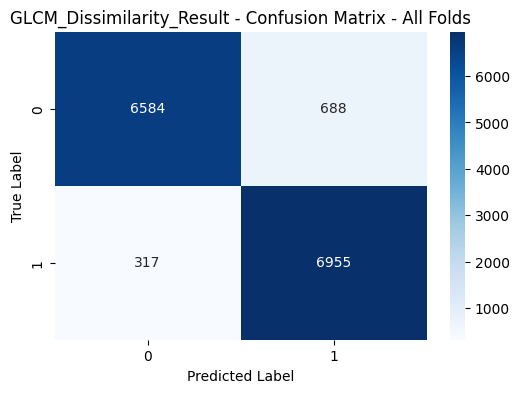

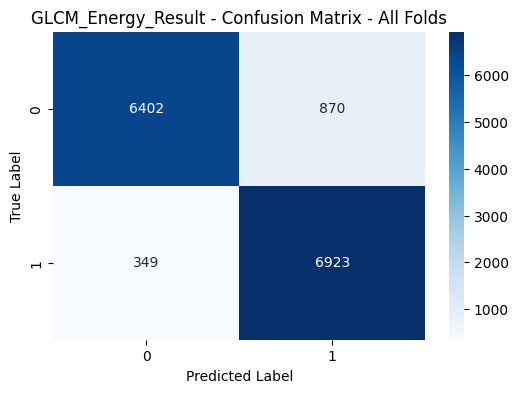

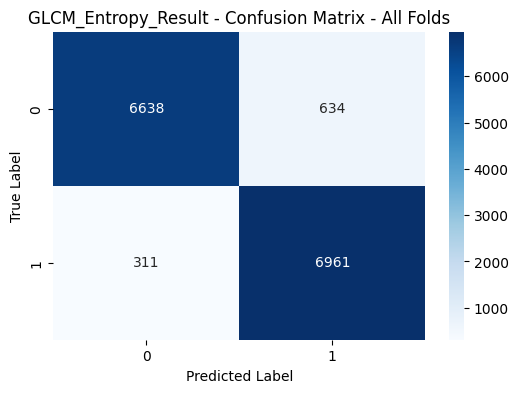

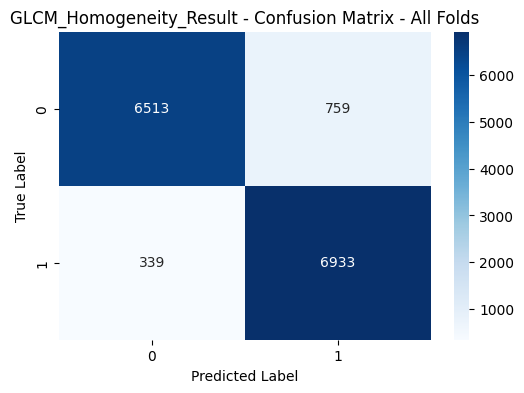

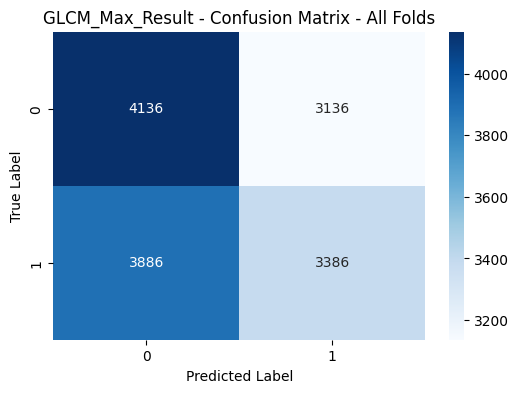

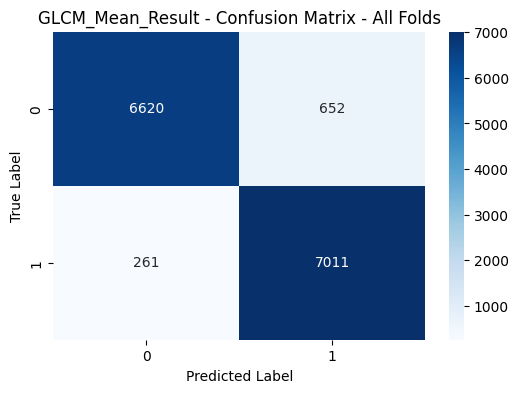

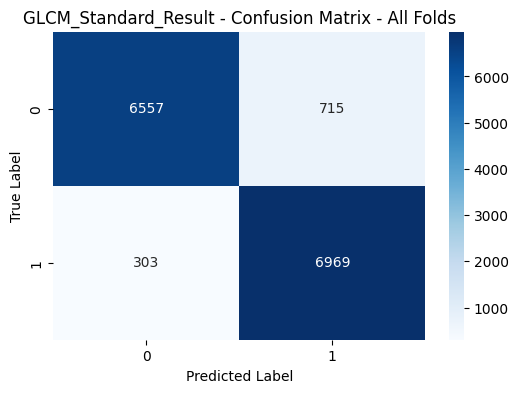

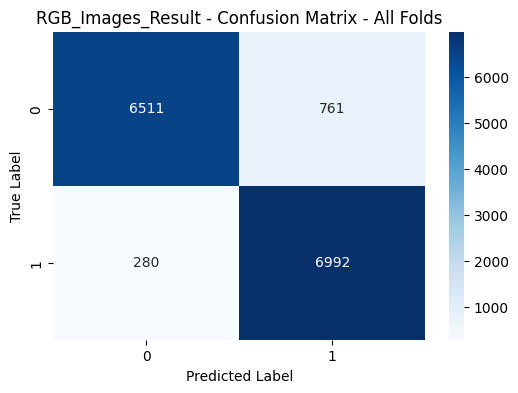

In [28]:
# **Step 6: Plot and compare confusion matrices**
for i, folder in enumerate(folders):
    # Merge confusion matrix data for all folds
    cm_data = pd.concat(all_confusion_matrices[i], ignore_index=True)
    cm = confusion_matrix(cm_data["true_labels"], cm_data["predicted_labels"])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{folder} - Confusion Matrix - All Folds")
    plt.show()

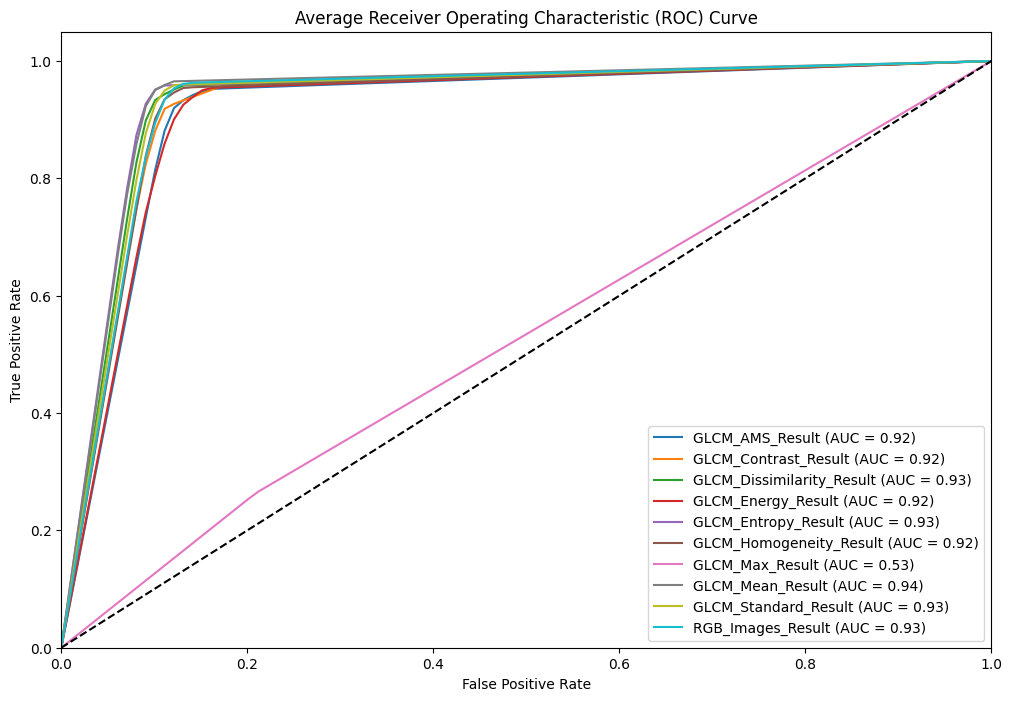

In [53]:
# **Step 4: Plot average ROC curves**
plt.figure(figsize=(12, 8))
for i, folder in enumerate(folders):
    fprs = []
    tprs = []
    for fold in range(10):
        fpr, tpr, _ = roc_curve(all_confusion_matrices[i][fold]["true_labels"],
                                 all_confusion_matrices[i][fold]["predicted_labels"])
        fprs.append(fpr)
        tprs.append(tpr)
    # interpolate with linear interpolation
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fprs, tprs)], axis=0)
    # compute the average AUC
    avg_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label=f"{folder} (AUC = {avg_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")  

plt.show()

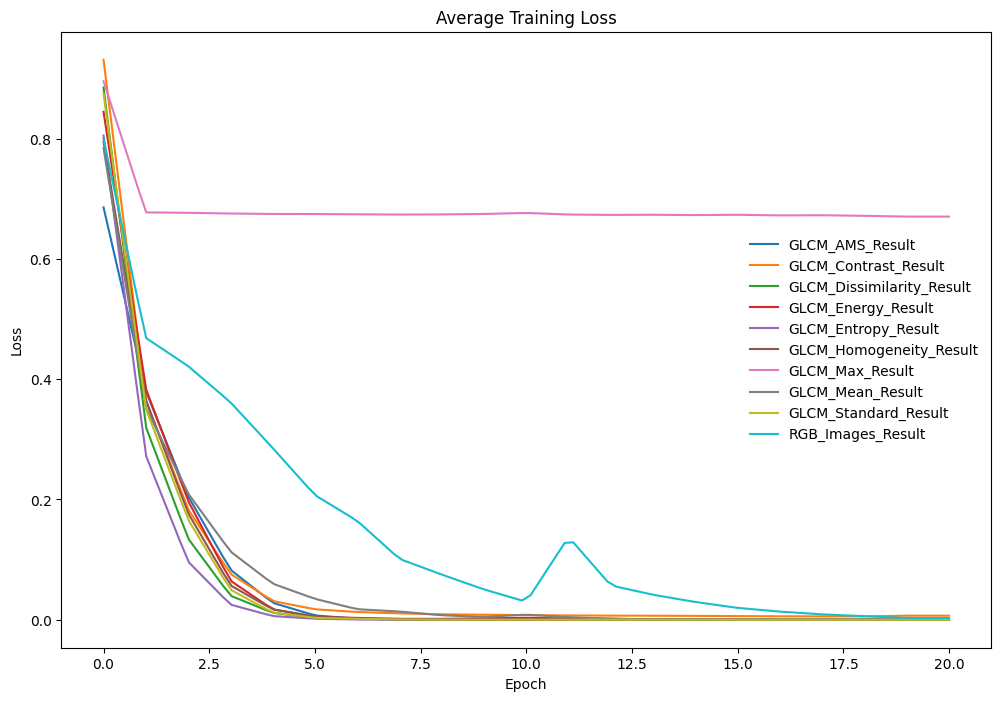

In [54]:
# **Step 4: Plot average training loss**
plt.figure(figsize=(12, 8))
for i, folder in enumerate(folders):
    train_losses = []
    for fold in range(10):
        train_loss = all_histories[i][fold]["train_loss"].values
        train_losses.append(train_loss)
    # interpolate with linear interpolation
    mean_epochs = np.linspace(0, len(train_losses[0]), 100)
    mean_train_loss = np.mean([np.interp(mean_epochs, np.arange(len(train_loss)), train_loss)
                               for train_loss in train_losses], axis=0)
    plt.plot(mean_epochs, mean_train_loss, label=f"{folder}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Average Training Loss")
# move the legend to the right at specified location
plt.legend(loc="right", frameon=False)   
plt.show()

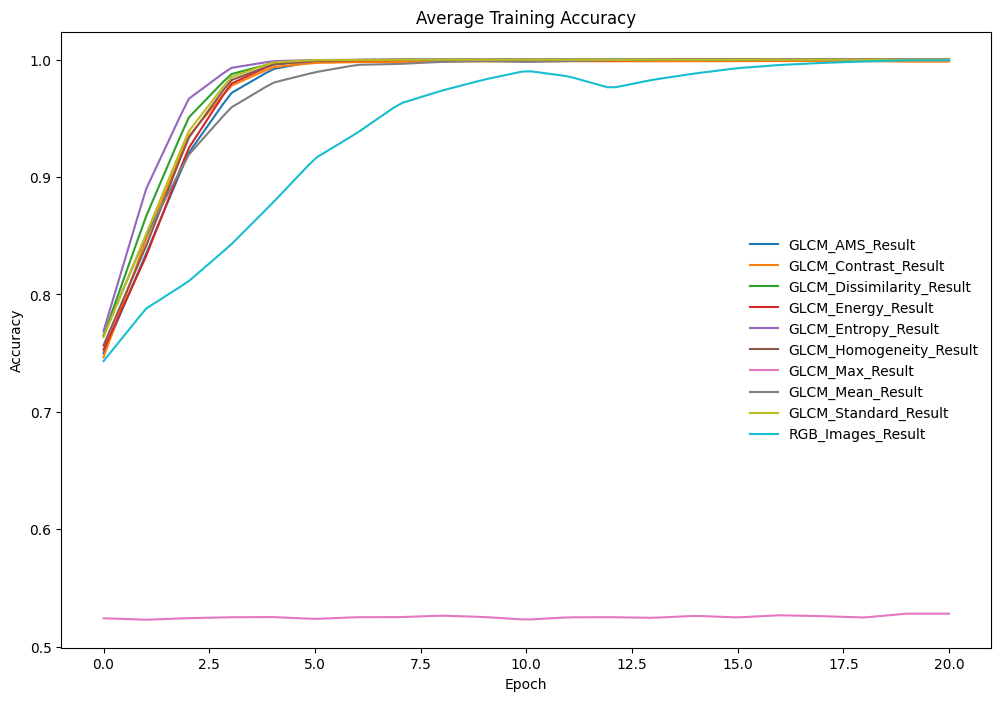

In [55]:
# **Step 4: Plot average training accuracy**
plt.figure(figsize=(12, 8))
for i, folder in enumerate(folders):
    train_accs = []
    for fold in range(10):
        train_acc = all_histories[i][fold]["train_acc"].values
        train_accs.append(train_acc)
    # interpolate with linear interpolation
    mean_epochs = np.linspace(0, len(train_accs[0]), 100)
    mean_train_acc = np.mean([np.interp(mean_epochs, np.arange(len(train_acc)), train_acc)
                               for train_acc in train_accs], axis=0)
    plt.plot(mean_epochs, mean_train_acc, label=f"{folder}")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Average Training Accuracy")
# move legend to center right and remove the frame
plt.legend(loc="center right", frameon=False)
plt.show()

C:\Users\buntu\AppData\Local\Temp\ipykernel_15724\3504975452.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(test_accs, labels=xLabels)


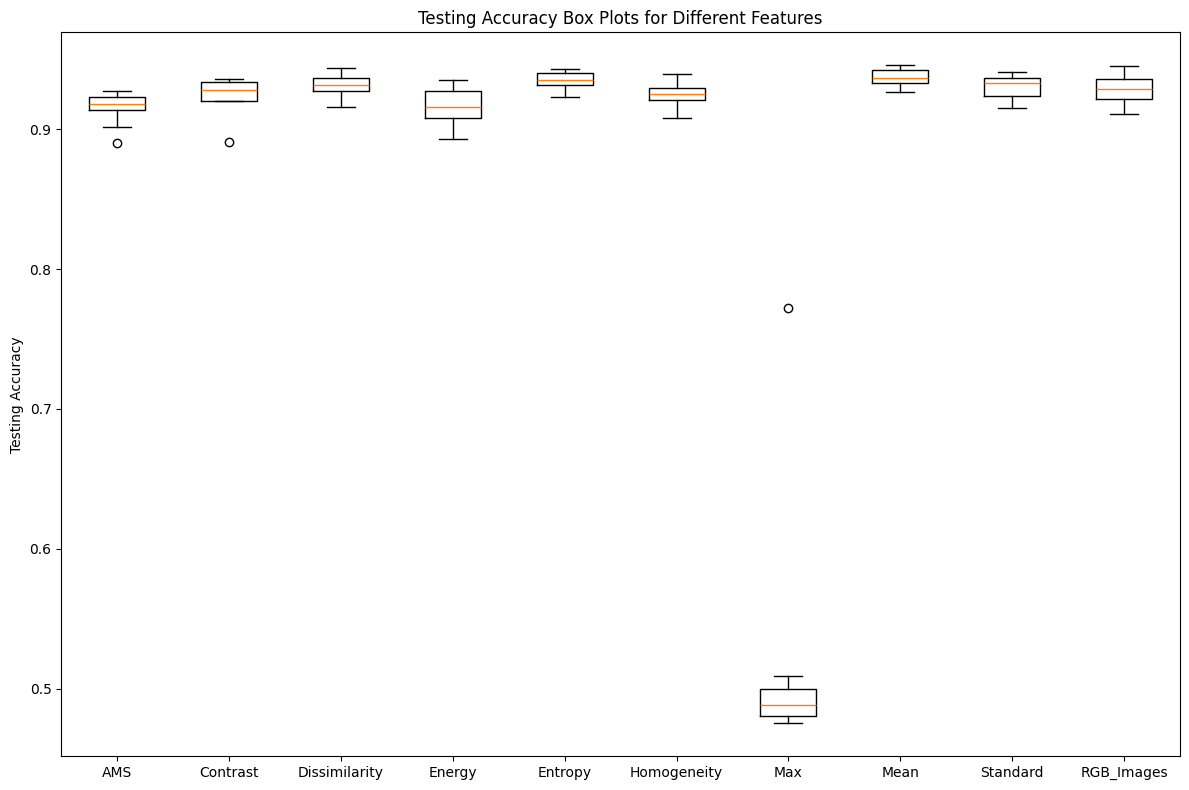

In [57]:
# **Step 4: Plot box plots of testing accuracy**
xLabels = ["AMS", "Contrast", "Dissimilarity", "Energy", "Entropy",
           "Homogeneity", "Max", "Mean", "Standard", "RGB_Images"]
plt.figure(figsize=(12, 8))
test_accs = []
for i, folder in enumerate(folders):
    fold_accs = []
    for fold in range(10):
        fold_acc = all_histories[i][fold]["val_acc"].values[-1]  # Get the last value (final epoch accuracy)
        fold_accs.append(fold_acc)
    test_accs.append(fold_accs)

plt.boxplot(test_accs, labels=xLabels)
# plt.xlabel("Features")
plt.ylabel("Testing Accuracy")
plt.title("Testing Accuracy Box Plots for Different Features")
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()